In [2]:
from pathlib import Path
from tqdm.notebook import tqdm
from tabulate import tabulate
import random, json
import pycountry
from iso639 import languages
import networkx as nx
from dateutil import parser
from datetime import datetime
from collections import Counter
from langdetect import detect
from omnibelt import load_json, save_json

In [14]:
from wordcloud import WordCloud
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from rake_nltk import Rake
import spacy
# from sklearn.cluster import DBSCAN
# import numpy as np

stop_words = set(stopwords.words('english'))
stop_words.update("'s", '|', 'I', "n't", "`s", "'s", 'n`t')

# nlp = spacy.load('en_core_web_md')

In [ ]:
import Levenshtein
from unidecode import unidecode
import unicodedata

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
lang_clusters = {'en': ['au', 'ca', 'gb', 'ie', 'in', 'my', 'ng', 'nz', 'ph', 'sa', 'sg', 'us', 'za'],
				 'es': ['ar', 'co', 'cu', 'mx', 've'], 'de': ['at', 'ch', 'de'], 'fr': ['be', 'fr', 'ma'],
				 'zh': ['cn', 'hk', 'tw'], 'ar': ['ae', 'eg'], 'pt': ['br', 'pt'], 'bg': ['bg'], 'cs': ['cz'],
				 'el': ['gr'], 'he': ['il'], 'hu': ['hu'], 'id': ['id'], 'it': ['it'], 'ja': ['jp'], 'ko': ['kr'],
				 'lt': ['lt'], 'lv': ['lv'], 'nl': ['nl'], 'no': ['no'], 'pl': ['pl'], 'ro': ['ro'], 'ru': ['ru'],
				 'sv': ['se'], 'sl': ['si'], 'sk': ['sk'], 'sr': ['rs'], 'th': ['th'], 'tr': ['tr'], 'uk': ['ua']}
loc_names = {'gb': 'United Kingdom', 'ar': 'Argentina', 'pl': 'Poland', 'sk': 'Slovakia', 'us': 'United States',
			 'eg': 'Egypt', 'no': 'Norway', 'ph': 'Philippines', 'at': 'Austria', 'rs': 'Serbia', 'tw': 'Taiwan',
			 'be': 'Belgium', 'cu': 'Cuba', 'sa': 'Saudi Arabia', 'th': 'Thailand', 'id': 'Indonesia',
			 'ru': 'Russian Federation', 'ch': 'Switzerland', 'fr': 'France', 'lt': 'Lithuania', 'tr': 'Turkey',
			 'de': 'Germany', 'cz': 'Czechia', 'pt': 'Portugal', 'ae': 'United Arab Emirates', 'it': 'Italy',
			 'cn': 'China', 'lv': 'Latvia', 'nl': 'Netherlands', 'hk': 'Hong Kong', 'ca': 'Canada', 'br': 'Brazil',
			 'hu': 'Hungary', 'kr': 'Korea', 'si': 'Slovenia', 'au': 'Australia', 'my': 'Malaysia', 'ie': 'Ireland',
			 'ua': 'Ukraine', 'in': 'India', 'ma': 'Morocco', 'bg': 'Bulgaria', 'ng': 'Nigeria', 'il': 'Israel',
			 'se': 'Sweden', 'za': 'South Africa', 've': 'Venezuela', 'nz': 'New Zealand', 'jp': 'Japan',
			 'sg': 'Singapore', 'gr': 'Greece', 'mx': 'Mexico', 'co': 'Colombia', 'ro': 'Romania'}
lang_names = {'en': 'English', 'ko': 'Korean', 'ru': 'Russian', 'es': 'Spanish', 'pt': 'Portuguese', 'cs': 'Czech',
			  'tr': 'Turkish', 'nl': 'Dutch', 'ar': 'Arabic', 'fr': 'French', 'bg': 'Bulgarian', 'id': 'Indonesian',
			  'sk': 'Slovak', 'el': 'Greek', 'he': 'Hebrew', 'sr': 'Serbian', 'hu': 'Hungarian', 'th': 'Thai',
			  'zh': 'Chinese', 'no': 'Norwegian', 'sl': 'Slovenian', 'sv': 'Swedish', 'de': 'German', 'lv': 'Latvian',
			  'pl': 'Polish', 'it': 'Italian', 'ro': 'Romanian', 'lt': 'Lithuanian', 'ja': 'Japanese',
			  'uk': 'Ukrainian'}
cluster_id = {loc: lang for lang, locs in lang_clusters.items() for loc in locs}
len(cluster_id)

54

In [4]:
def show_date(date):
	return date.strftime('%d %b%y')
def get_locs(article):
	return [f'{loc_names[loc]}' for loc in sorted(set(i['location'] for i in article['instances']))]
def get_cats(article):
	return [f'<{cat}>' for cat in sorted(set(i['category'] for i in article['instances']))]
def view_article(art, detailed=False):
	cats = ' '.join(get_cats(art))
	locs = ', '.join(map(repr, get_locs(art)))
	published = parser.parse(art['publishedAt'])
	collected = [parser.parse(i['collectedAt']) for i in art['instances']]
	first = min(collected)
	last = max(collected)
	timing = f'{show_date(first)}' if first == last else f'{show_date(first)} - {show_date(last)}'

	lines = []
	if 'en-title' in art:
		lines.append(f'English Title: {art["en-title"]!r}')
	lines.append(f'{lang_names[art["language"]]} Title: {art["title"]!r}')
	lines.append(f'Categories: {cats}  ---   {locs} ({timing})  ---  {art["source-name"]}')

	if detailed:
		added_desc = False
		desc = art.get('description')
		en_desc = art.get('en-description')
		if en_desc is not None and len(en_desc):
			lines.append(f'English Description: {en_desc}')
			added_desc = True
		if desc is not None and len(desc):
			lines.append(f'{lang_names[art["language"]]} Description: {desc}')
			added_desc = True
		if not added_desc:
			lines.append(f'- No description -')
	print('\n'.join(lines))

In [5]:
root = Path('/home/fleeb/workspace/local_data/nnn')
recs = (root / 'babel-briefings-v1').glob('**/*.json')
recs = list(recs)
len(recs)
articles = []
for rec in tqdm(recs):
	articles.extend(load_json(rec))
len(articles)

  0%|          | 0/54 [00:00<?, ?it/s]

4719199

In [6]:
by_loc = {}
by_lang = {}
by_source = {}
by_ID = {}
for article in tqdm(articles):
	by_ID[article['ID']] = article
	# article['published'] = parser.parse(article['publishedAt'])
	by_source.setdefault(article['source-name'], []).append(article)
	by_lang.setdefault(article['language'], []).append(article)
	for instance in article['instances']:
		# instance['collected'] = parser.parse(instance['collectedAt'])
		by_loc.setdefault(instance['location'], []).append(article)
len(by_loc), len(by_lang)

  0%|          | 0/4719199 [00:00<?, ?it/s]

(54, 30)

In [12]:


nlp = spacy.load('en_core_web_md')
# rake_nltk_var = Rake()
# lemmatizer = WordNetLemmatizer()

NameError: name 'spacy' is not defined

In [ ]:
noun_phrases = []
for headline in headlines:
    doc = nlp(headline)
    for p in doc.noun_chunks:
        noun_phrases.append(str(p))

# Convert noun phrases to vectors
vectors = [nlp(p).vector for p in noun_phrases]

# Apply DBSCAN clustering
clustering = DBSCAN(eps=0.5, min_samples=1, metric='cosine').fit(np.array(vectors))
labels = clustering.labels_

# Group noun phrases based on clustering results
groups = {}
for np, label in zip(noun_phrases, labels):
    if label not in groups:
        groups[label] = []
    groups[label].append(np)

# Print the grouped noun phrases
for label, nps in groups.items():
    print(f"Group {label}: {nps}")

  0%|          | 0/4719199 [00:00<?, ?it/s]

27116

In [7]:
batch = by_lang['de']
len(batch)

259718

In [8]:
art = random.choice(batch)
view_article(art, detailed=True)
print(art['source-name'])

English Title: 'WhatsApp opens up unimagined possibilities: When will this audio function come? - inside digital'
German Title: 'WhatsApp eröffnet ungeahnte Möglichkeiten: Wann kommt diese Audio-Funktion? - inside digital'
Categories: <technology>  ---   'Germany' (04 Oct21 - 05 Oct21)
English Description: The recipient of voice messages on WhatsApp can only listen and wait while listening. At least until now.
German Description: Der Empfänger von Sprachnachrichten bei WhatsApp kann während des Abhörens nur zuhören und abwarten. Zumindest bis jetzt.
inside digital


In [95]:
sources = {}
for art in batch:
	sources.setdefault(art['source-name'], []).append(art)
len(sources)

1437

In [119]:
src, arts = random.choice(list(sources.items()))
src, len(arts)

('Www.otz.de', 5)

In [120]:
segs = [a.get('en-title', art['title']).split(' - ') for a in arts]
segs

[['Ex-basketball player Dirk Nowitzki extends contract with Thüringer Bauerfeind AG',
  'Ostthüringer Zeitung'],
 ['No stadium solution for Viktoria Berlin: FC Carl Zeiss Jena as a beneficiary?',
  'Ostthüringer Zeitung'],
 ['Thuringian State Observatory measures over 8,000 potential threats to the Earth',
  'Ostthüringer Zeitung'],
 ['Participants from Jena wanted for study on corona consequences',
  'Thuringian state newspaper'],
 ['Greiz district: Introduced viruses are becoming more common',
  'Ostthüringer Zeitung']]

In [8]:
# endterms = [x.get('en-title', art['title']).split(' - ')[-1] for x in xs]
# endterms

In [55]:
def str_similarity(string1: str, string2: str):
	distance = Levenshtein.distance(string1, string2)
	similarity = 1 - (distance / max(len(string1), len(string2)))
	return similarity
def capsim(s1, s2):
	s1, s2 = unidecode(s1), unidecode(s2)
	return (str_similarity(s1.lower(), s2.lower()) + str_similarity(s1, s2)) / 2

In [18]:
todo = list(articles)
pbar = tqdm(total=len(todo))

  0%|          | 0/4719199 [00:00<?, ?it/s]

In [ ]:
# eng vs orig
# source-name
# suffix degree

class Enders:
	def __init__(self, world):
		self.en = {}
		self.orig = {}

In [61]:
def add_title(table, src, title):
	key = unidecode(src)
	if key not in table:
		table[key] = []
	segs = unidecode(title).split(' - ')[1:]
	for i, seg in enumerate(reversed(segs)):
		if i >= len(table[key]):
			table[key].append(Counter())
		cnt = table[key][i]
		cnt.update([seg])

In [62]:
orig_table = {}
engl_table = {}

for src, arts in tqdm(by_source.items()):
	for art in arts:
		add_title(orig_table if 'en-title' in art else engl_table, src, art['title'])
		if 'en-title' in art:
			add_title(engl_table, src, art['en-title'])

  0%|          | 0/27116 [00:00<?, ?it/s]

In [69]:
sel = [art for art in by_loc['hu'] if art.get('en-title', '').endswith('PC Forum publishes a keyboard with only number keys')]
art = random.choice(sel)
view_article(art, detailed=True)

English Title: 'Microsoft - PC Forum publishes a keyboard with only number keys'
Hungarian Title: 'Csak számgombokból álló billentyűzetet ad ki a Microsoft - PC Fórum'
Categories: <technology>  ---   'Hungary' (03 Oct20 - 06 Oct20)  ---  Pcforum.hu
English Description: Welcome to the PC Forum!
Hungarian Description: Üdvözlünk a PC Fórum-n!


In [98]:



class SmartFilter:
	def __init__(self, art):
		self.art = art
		self.base = art.get('en-title', art['title'])
		self.orig_base = art['title'] if 'en-title' in art else self.base
		src = art['source-name']
		common = by_source[src]
		endings = Counter([common.get('en-title', art['title']).split(' - ')[-1] for common in common])
		self.src = src
		self.endings = endings
		
		
	def clean_title(self):
		base = self.base
		orig_base = self.orig_base
		
		segs = base.split(' - ')
		
		assert len(segs) == 2, f'Bad title: {base!r}'
		
		while len(segs) > 1:
			cand = segs.pop()
			
			
			
			pass
		
		return segs[0]
		

def preprocess_title(art):
	base = art.get('en-title', art['title'])
	orig_base = art['title'] if 'en-title' in art else base
	segs = base.split(' - ')
	
	assert len(segs) == 2, f'Bad title: {base!r}'
	
	while len(segs) > 1:
		cand = segs.pop()
		
		
		
		pass
	
	return segs[0]
	
	if len(segs) == 1:
		return base
	if len(segs) > 2:
		info, *rest = segs
		return info
	return segs[0]

In [20]:
while len(todo):
	art = todo.pop()
	try:
		clean = preprocess_title(art)
	except:
		todo.append(art)
		raise
	else:
		pbar.update(1)

AssertionError: Bad title: 'Hrdina Pastrňák. Český kanonýr rozhodl tři minuty před koncem o výhře Bostonu - Aktuálně.cz - Aktuálně.cz'

In [29]:
view_article(art, detailed=True)

English Title: 'The hero Pastrňák. The Czech gunner decided to win Boston three minutes before the end - Aktuálně.cz - Aktuálně.cz'
Czech Title: 'Hrdina Pastrňák. Český kanonýr rozhodl tři minuty před koncem o výhře Bostonu - Aktuálně.cz - Aktuálně.cz'
Categories: <sports>  ---   'Czechia' (29 Nov21)  ---  Aktualne.cz
English Description: The Czech forward made his mark on the power play when he scored his seventh goal of the season after Brad Marchand's cross pass across the goal area.
Czech Description: Český útočník se prosadil v přesilové hře, kdy po křižné přihrávce Brada Marchanda přes brankoviště vstřelil svůj sedmý gól v sezoně.


In [49]:
src = art['source-name']
common = by_source[src]
endings = Counter([common.get('en-title', art['title']).split(' - ')[-1] for common in common])
len(common)

4538

In [48]:
capsim('Apple announces new iPhone', 'Apple announces new iPhone')

1.0

In [51]:
base = art.get('en-title', art['title'])
orig_base = art['title'] if 'en-title' in art else base
segs = base.split(' - ')

In [52]:
cand = segs[-1]
cand

'Aktuálně.cz'

In [57]:
capsim(src, cand), src, cand

(1.0, 'Aktualne.cz', 'Aktuálně.cz')

In [111]:
# def to_prompt(art):
# 	title = art.get('en-title', art['title'])
# 	# rake_nltk_var.extract_keywords_from_text(title)
# 	desc = art.get('en-description', art['description'])
# 	if desc is not None and len(desc):
# 		pass
# 		# rake_nltk_var.extract_keywords_from_text(desc)
# 	else:
# 		desc = ''
# 	content = art.get('en-content', art['content'])
# 	if content is not None and len(content):
# 		pass
# 		# rake_nltk_var.extract_keywords_from_text(content)
# 	else:
# 		content = ''
# 	
# 	text = f'{title}\n{desc}\n{content}'
# 	return text

def preprocess_title(art):
	base = art.get('en-title', art['title'])
	src = art['source-name']
	title = base.replace(src, '')
	return title





In [147]:
art = random.choice(batch)
view_article(art, detailed=True)
title = preprocess_title(art)
title_doc = nlp(title)
# lemmatized_tokens = [token.lemma_.lower() for token in doc if str(token).lower() not in stopwords.words('english')]
# print(lemmatized_tokens)
# raw_nouns = list(title_doc.noun_chunks)
# raw_verbs = [token for token in title_doc if token.pos_ == "VERB"]
# print()
# print(raw_nouns)
# print(raw_verbs)
key_terms = Counter([token.lemma_.lower() for chunk in title_doc.noun_chunks for token in chunk])
key_terms

English Title: "Ripple's Blockchain Report: Will Central Bank Digital Currencies Overtake Bitcoin? - finanzen.net"
German Title: 'Ripples Blockchain-Bericht: Werden digitale Zentralbankwährungen Bitcoin den Rang ablaufen? - finanzen.net'
Categories: <technology>  ---   'Austria' (04 Nov20 - 05 Nov20)  ---  Finanzen.net
English Description: In recent years, cryptocurrencies have come more and more into the spotlight and even become known to the masses. The shift in the trend towards blockchain technology also brought governments to work on so-called CBDCs.
German Description: In den vergangenen Jahren rückten Kryptowährungen immer stärker ins Rampenlicht und wurden sogar der Masse ein Begriff. Die Verschiebung des Trends Richtung Blockchain-Technologie rief auch Regierungen auf den Plan, die an sogenannten CBDCs arbeiten.


Counter({'ripple': 1,
         "'s": 1,
         'blockchain': 1,
         'report': 1,
         'central': 1,
         'bank': 1,
         'digital': 1,
         'currencies': 1,
         'bitcoin': 1,
         'finanzen.net': 1})

In [158]:
def get_title(art):
	return art.get('en-title', art['title'])
def article_title_bag(art):
	title = art.get('en-title', art['title'])
	title_doc = nlp(title)
	key_terms = Counter([token.lemma_.lower() for chunk in title_doc.noun_chunks for token in chunk])
	return key_terms

In [150]:
todo = list(articles)
pbar = tqdm(total=len(todo))
bags = {}
def process_additional(n=100):
	batch_pbar = tqdm(total=min(n, len(todo)))
	while len(todo) and batch_pbar.n < n:
		art = todo.pop()
		if art['ID'] in bags:
			continue
		try:
			bag = article_title_bag(art)
		except:
			todo.append(art)
			raise
		else:
			bags[art['ID']] = bag
			pbar.update(1)
			batch_pbar.update(1)

  0%|          | 0/4719199 [00:00<?, ?it/s]

In [180]:
process_additional(10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [191]:
query = 'ahn sang suu kyi'
# query = 'iphone'
query = 'alibaba'
qdoc = nlp(query)
qtokens = [token.lemma_.lower() for token in qdoc]
qkeys = set(qtokens)

In [207]:
min_hits = None
matches = Counter()
for ID, bag in bags.items():
	hits = qkeys.intersection(bag.keys())
	if len(hits) and (min_hits is None or len(hits) >= min_hits):
		matches[ID] = len(hits)
len(matches)

1

In [193]:
sel = [by_ID[ID] for ID, score in matches.most_common(10)]

for art in sel[:4]:
	view_article(art, detailed=False)
	print()

English Title: 'The cloud of Alibaba and Baidu is coming into the crosshairs of the Chinese authorities - Patria.cz'
Czech Title: 'Do hledáčku čínských úřadů se dostává cloud Alibaby a Baidu - Patria.cz'
Categories: <technology>  ---   'Czechia' (23 Nov21)  ---  Patria.cz

English Title: 'They brought out reports of the rape, it cost them the place. Alibaba fired 10 people - iDNES.cz'
Czech Title: 'Vynesli zprávy o znásilnění, stálo je to místo. Alibaba propustila 10 lidí - iDNES.cz'
Categories: <business> <general>  ---   'Czechia' (31 Aug21)  ---  Idnes.cz

English Title: 'Alibaba receives another blow in the form of Chinese regulations - Kurzy.cz'
Czech Title: 'Alibaba dostává další ránu v podobě čínských regulací - Kurzy.cz'
Categories: <business>  ---   'Czechia' (25 Aug21)  ---  Kurzy.cz

English Title: 'Billion dollar fine sent Alibaba into a loss. No problem, we will pay, responds the company - iDNES.cz'
Czech Title: 'Miliardová pokuta poslala Alibabu do ztráty. Není problém, z

In [9]:
bagowords = {int(ID): bag for ID, bag in load_json(root/'bagowords.json').items()}

  0%|          | 0/4719199 [00:00<?, ?it/s]

In [202]:
for art in tqdm(articles):
	if art['ID'] not in bagowords:
		bagowords[art['ID']] = Counter([token.lemma_ for token in nlp(unidecode(art.get('en-title', art['title'])))])
len(bagowords)

  0%|          | 0/4719199 [00:00<?, ?it/s]

4719199

In [204]:
# save_json(bagowords, root/'bagowords.json');

In [10]:
lowords = {ID: {k.lower(): v for k,v in bag.items()} for ID, bag in tqdm(bagowords.items())}

  0%|          | 0/4719199 [00:00<?, ?it/s]

In [15]:
query = 'ahn sang suu kyi'
# query = 'iphone'
query = 'alibaba'
# query = 'myanmar burma coup burmese military ahn sang suu kyi aung san aun'
query = 'ahn sang suu kyi aung san aun myanmar burma burmese'
qdoc = nlp(query)
qtokens = [token.lemma_.lower() for token in qdoc]
qkeys = set(qtokens)
print(qkeys)

{'kyi', 'san', 'aung', 'burma', 'myanmar', 'sing', 'ahn', 'aun', 'burmese', 'suu'}


In [16]:
min_hits = 3
matches = Counter()
for ID, bag in tqdm(bagowords.items()):
	hits = qkeys.intersection([k.lower() for k in bag.keys()])
	if len(hits) and (min_hits is None or len(hits) >= min_hits):
		matches[ID] = len(hits)
len(matches)

  0%|          | 0/4719199 [00:00<?, ?it/s]

160

In [320]:
# matches = Counter([art['ID'] for art in tqdm(articles) if 'suu kyi' in unidecode(art.get('en-title', art['title']).lower())])
# len(matches)

In [18]:
sel = [by_ID[ID] for ID, score in matches.most_common(10)]
art = random.choice(sel)
view_article(art)

English Title: 'Burma: As protests continue, Aung San Suu Kyi indicted again - 20 Minutes'
French Title: 'Birmanie : Pendant que les manifestations se poursuivent, Aung San Suu Kyi de nouveau inculpée - 20 Minutes'
Categories: <general>  ---   'France' (17 Feb21)  ---  20 Minutes


In [20]:
insts = []
for ID in matches:
	art = by_ID[ID]
	insts.extend({
					 'language': art['language'], 
					 **inst, 
					 'ID': f'{str(art["ID"]).zfill(7)}-{str(i).zfill(3)}',
					 'title': art.get('en-title', art['title']),
				  } for i, inst in enumerate(art['instances']))
tbl = pd.DataFrame(insts)
tbl['collectedAt'] = pd.to_datetime(tbl['collectedAt'])
tbl = tbl.sort_values('collectedAt')
tbl['date'] = tbl['collectedAt'].dt.date
tbl

,language,collectedAt,location,category,ID,title,date
141,th,2020-09-03 06:55:00+00:00,th,general,0547450-000,Suu Kyi points out that Myanmar faces 'COVID d...,2020-09-03
5,en,2020-11-06 13:38:00+00:00,sa,general,1743778-000,Aung San Suu Kyi: Myanmar democracy icon who f...,2020-11-06
6,en,2020-11-06 13:38:00+00:00,us,general,1743778-001,Aung San Suu Kyi: Myanmar democracy icon who f...,2020-11-06
71,en,2020-11-07 11:01:00+00:00,us,general,1757195-000,"Despite accusations of genocide, Aung San Suu ...",2020-11-07
7,en,2020-11-07 11:01:00+00:00,sa,general,1758980-000,A look at Myanmar's election and Suu Kyi's exp...,2020-11-07
...,...,...,...,...,...,...,...
53,en,2021-06-19 08:29:00+00:00,ph,general,5245848-000,Myanmar protesters wear flowers to mark Suu Ky...,2021-06-19
119,en,2021-06-20 11:34:00+00:00,my,general,5260902-000,Myanmar protesters wear flowers to mark Suu Ky...,2021-06-20
109,en,2021-06-29 09:06:00+00:00,sg,general,5426173-000,Myanmar's Aung San Suu Kyi urges people to be ...,2021-06-29
54,en,2021-09-17 11:47:00+00:00,ph,general,6494786-000,Myanmar junta to put Suu Kyi on trial for corr...,2021-09-17


In [21]:
cat = 'language'
grouped_df = tbl.groupby(['date', cat]).size().reset_index(name='counts')


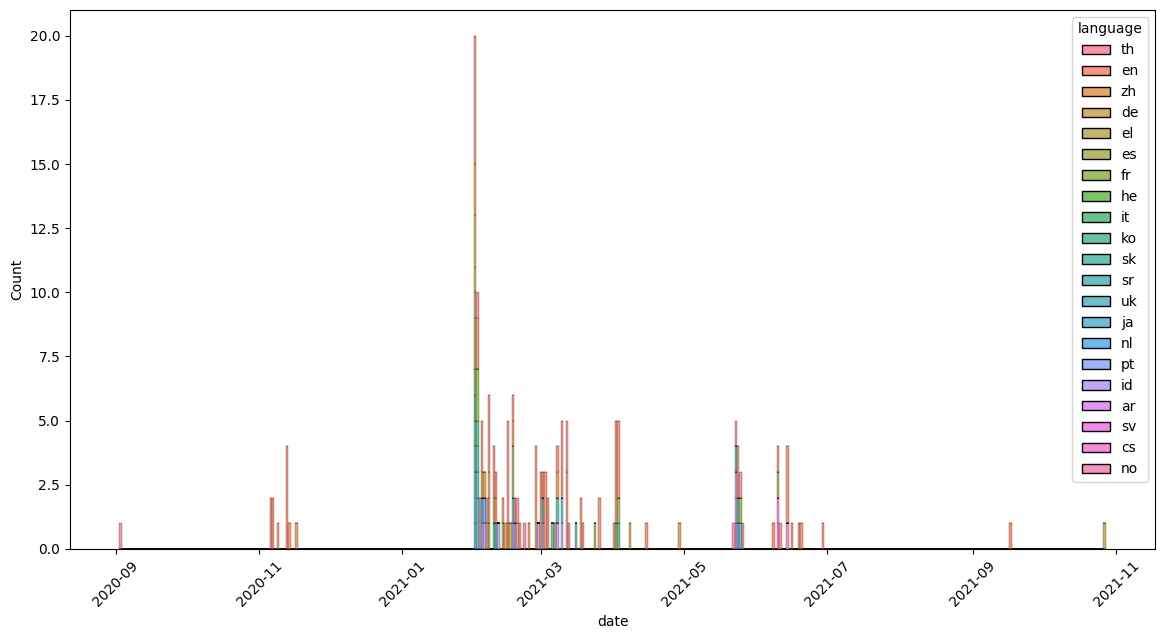

In [22]:
plt.figure(figsize=(14, 7))
sns.histplot(data=grouped_df, x='date', weights='counts', hue=cat, multiple='stack')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45);

In [27]:
def inst_id(art_id, inst_idx):
	return f'{str(art_id).zfill(7)}-{str(inst_idx).zfill(3)}'
def get_inst(inst_id):
	art_id, inst_idx = inst_id.split('-')
	art = by_ID[art_id]
	inst = art['instances'][int(inst_idx)]
	return {**inst, **art}
def art_row(art):
	return {'aid': art['ID'], 'title': art.get('en-title', art['title']), 'source': art['source-name'], 'language': art['language']}

In [28]:
df = pd.DataFrame([{**row, **inst, 'iid': inst_id(row['aid'], i)} for row in tqdm([art_row(art) for art in articles]) for i, inst in enumerate(by_ID[row['aid']]['instances'])])
df['collectedAt'] = pd.to_datetime(df['collectedAt'])
df = df.sort_values('collectedAt')
df['date'] = df['collectedAt'].dt.date
len(df)

  0%|          | 0/4719199 [00:00<?, ?it/s]

7419089

In [29]:
daybags = {}
date_aids = dict(df.groupby('date')['aid'].apply(list))
for date, aIDs in tqdm(sorted(date_aids.items())):
	total = Counter()
	for aID in aIDs:
		total.update({k.lower(): v for k,v in bagowords[aID].items()})
	daybags[date] = total
len(daybags)

  0%|          | 0/413 [00:00<?, ?it/s]

413

In [ ]:
deltas = {}
dates = list(daybags.keys())
for d1, d2 in tqdm(zip(dates[:-1], dates[1:]),total=len(dates)-1):
	delta = daybags[d2] - daybags[d1]
	deltas[d2] = delta

  0%|          | 0/412 [00:00<?, ?it/s]

In [ ]:
len(deltas[datetime(2021, 2, 1).date()])

In [451]:
target = datetime(2021, 2, 1).date()
# sel = random.choices(date_aids[target], k=10)
# df[df['aid'].isin(sel)]
df[df['date'] == target]

,aid,title,source,language,collectedAt,location,category,iid,date
6339958,2907816,The most notable new products in online cinema...,Newsru.com,ru,2021-02-01 14:11:00+00:00,ru,general,2907816-000,2021-02-01
6339955,2907800,Samsung will copy a feature from LG that could...,Cnews.ru,ru,2021-02-01 14:11:00+00:00,ru,general,2907800-000,2021-02-01
6339962,2908166,“This is a challenge for me”: actor Zhidkov sh...,Teleprogramma.pro,ru,2021-02-01 14:11:00+00:00,ru,entertainment,2908166-000,2021-02-01
6339964,2908187,Platinum and molybdenum carbide helped produce...,Nplus1.ru,ru,2021-02-01 14:11:00+00:00,ru,science,2908187-000,2021-02-01
6339936,2905422,Fiber optic sensors will help monitor road qua...,Indicator.ru,ru,2021-02-01 14:11:00+00:00,ru,science,2905422-000,2021-02-01
...,...,...,...,...,...,...,...,...,...
6736386,2909440,Here’s how you can transfer WhatsApp chats to ...,The Hindu,en,2021-02-01 14:11:00+00:00,in,technology,2909440-000,2021-02-01
2021775,2906395,Shabana to Youm7 TV: Suleiman threatens Ajay’s...,Youm7.com,ar,2021-02-01 14:11:00+00:00,eg,sports,2906395-000,2021-02-01
2021776,2906416,What is the difference...the most prominent di...,Youm7.com,ar,2021-02-01 14:11:00+00:00,eg,entertainment,2906416-000,2021-02-01
6736387,2909558,"MediaTek Entered Apple’s Supply Chain, Will Sh...",Gizchina.com,en,2021-02-01 14:11:00+00:00,in,technology,2909558-000,2021-02-01


In [446]:
dt = deltas[target]
len(dt)

9073

In [447]:
keywords = Counter({w:f for w, f in dt.items() if any(not unicodedata.category(char).startswith('P') for char in w) and w not in stop_words})
len(keywords)

9005

In [440]:
# w, f = keywords.most_common()[0]
# w, f, any(not unicodedata.category(char).startswith('P') for char in w), w not in stop_words

In [450]:
print(tabulate(keywords.most_common(30)))

-------------  --
silver         82
liverpool      75
year           73
february       69
may            60
myanmar        49
international  44
1              43
transfer       42
coup           40
billion        36
eu             36
last           35
name           34
stock          34
science        33
get            33
channel        32
san            29
11             28
high           27
post           27
network        26
million        26
pfizer         26
military       26
investing.com  25
discover       25
speed          25
icloud         25
-------------  --


In [449]:
keywords['aung']

19

In [ ]:
sel = [ID for ID, bag in bagowords.items() if 'aung' in bag]

In [453]:
df[df['date'] == target][]

,aid,title,source,language,collectedAt,location,category,iid,date
6339958,2907816,The most notable new products in online cinema...,Newsru.com,ru,2021-02-01 14:11:00+00:00,ru,general,2907816-000,2021-02-01
6339955,2907800,Samsung will copy a feature from LG that could...,Cnews.ru,ru,2021-02-01 14:11:00+00:00,ru,general,2907800-000,2021-02-01
6339962,2908166,“This is a challenge for me”: actor Zhidkov sh...,Teleprogramma.pro,ru,2021-02-01 14:11:00+00:00,ru,entertainment,2908166-000,2021-02-01
6339964,2908187,Platinum and molybdenum carbide helped produce...,Nplus1.ru,ru,2021-02-01 14:11:00+00:00,ru,science,2908187-000,2021-02-01
6339936,2905422,Fiber optic sensors will help monitor road qua...,Indicator.ru,ru,2021-02-01 14:11:00+00:00,ru,science,2905422-000,2021-02-01
...,...,...,...,...,...,...,...,...,...
6736386,2909440,Here’s how you can transfer WhatsApp chats to ...,The Hindu,en,2021-02-01 14:11:00+00:00,in,technology,2909440-000,2021-02-01
2021775,2906395,Shabana to Youm7 TV: Suleiman threatens Ajay’s...,Youm7.com,ar,2021-02-01 14:11:00+00:00,eg,sports,2906395-000,2021-02-01
2021776,2906416,What is the difference...the most prominent di...,Youm7.com,ar,2021-02-01 14:11:00+00:00,eg,entertainment,2906416-000,2021-02-01
6736387,2909558,"MediaTek Entered Apple’s Supply Chain, Will Sh...",Gizchina.com,en,2021-02-01 14:11:00+00:00,in,technology,2909558-000,2021-02-01


In [77]:
# art['en-content']

In [102]:
verbs = [token.text for token in doc if token.pos_ == "VERB"]

print(verbs)  # Output: ['jumps']

['continue', 'has', 'find', 'continue', 'has']


In [77]:

text = to_prompt(art)
# rake_nltk_var.extract_keywords_from_text(text)
# keywords = rake_nltk_var.get_ranked_phrases()

tokens = word_tokenize(text)
tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]

# wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(' '.join(tokens))
# keywords = wordcloud.words_

# # tokens = word_tokenize(text.lower())  # Lowercasing
# tokens = word_tokenize(text)
lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

tags = pos_tag(lemmatized_tokens)
keywords = [word for word, pos in tags if pos in ['NN', 'NNP']]

keyword_freq = Counter(keywords)
# print(f'Input: {title!r}')
print(text)
print(tabulate(keyword_freq.most_common()))

Argentina's nuclear power plants achieved a record in electricity production - Facts.BG
The company operator of the Argentine nuclear power plants Nucleoéléctrica Argentina ..
Nuclear Power Argentina 2020, Grupo La Provincia. „“ 1 2 „“ 7,947 1 - 30 . , 2020 . , , 5,059 . „, “, .
---------------  -
Argentina        3
power            2
plant            2
„                2
record           1
electricity      1
production       1
Facts.BG         1
company          1
operator         1
Argentine        1
Nucleoéléctrica  1
..               1
Nuclear          1
Power            1
Grupo            1
La               1
Provincia        1
“                1
---------------  -


In [26]:
rake_nltk_var.extract_keywords_from_text(art['source-name'])
rake_nltk_var.get_ranked_phrases()

['today']

In [30]:
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

sentence = "Apple is looking at buying U.K. startup for $1 billion"
tokens = word_tokenize(sentence)
tags = pos_tag(tokens)
tree = ne_chunk(tags)
keywords = [leaf for leaf in tree if isinstance(leaf, nltk.Tree)]


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/fleeb/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/fleeb/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/fleeb/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [31]:
keywords

[Tree('GPE', [('Apple', 'NNP')])]

In [34]:
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize

nltk.download('punkt')

text = "This is a sample sentence, showing off the stop words filtration."
tokens = word_tokenize(text)
fdist = FreqDist(tokens)
keywords = [word for word, count in fdist.items() if count > 1]


[nltk_data] Downloading package punkt to /home/fleeb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
keywords

[]

In [38]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('averaged_perceptron_tagger')

text = "The quick brown fox jumps over the lazy dog"
tokens = word_tokenize(text)
tags = pos_tag(tokens)
keywords = [word for word, pos in tags if pos in ['NN', 'NNP']]
keywords

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/fleeb/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


['brown', 'fox', 'dog']

In [7]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package wordnet to /home/fleeb/nltk_data...
[nltk_data] Downloading package punkt to /home/fleeb/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
from rake_nltk import Rake

rake_nltk_var = Rake()
text = "This is a sample sentence, showing off the stop words filtration."
rake_nltk_var.extract_keywords_from_text(text)
keyword_ranked_phrases = rake_nltk_var.get_ranked_phrases()


In [13]:
keyword_ranked_phrases

['stop words filtration', 'sample sentence', 'showing']

In [63]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample headlines
headlines = [
    "Climate Change: A Global Challenge",
    "Tech Giants Face Antitrust Lawsuits",
    "Stock Market Hits Record High"
]

# Preprocess text
preprocessed_headlines = [headline.lower() for headline in headlines]

# Create TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_df=0.85, max_features=10, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(preprocessed_headlines)

# Extract keywords
feature_names = vectorizer.get_feature_names_out()
keywords = [feature_names[idx] for idx in tfidf_matrix.sum(axis=0).argsort()[0, ::-1]]
print(keywords)


[array([['hits', 'high', 'lawsuits', 'global', 'giants', 'face',
        'climate', 'change', 'challenge', 'antitrust']], dtype=object)]


In [64]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [69]:
doc = nlp(text)
# lemmatizer = nlp.add_pipe("lemmatizer")
# This usually happens under the hood
# processed = lemmatizer(doc)
# processed
doc

Argentina's nuclear power plants achieved a record in electricity production - Facts.BG
The company operator of the Argentine nuclear power plants Nucleoéléctrica Argentina ..
Nuclear Power Argentina 2020, Grupo La Provincia. „“ 1 2 „“ 7,947 1 - 30 . , 2020 . , , 5,059 . „, “, .

In [76]:
lemmatized_tokens = [token.lemma_.lower() for token in doc if str(token).lower() not in stopwords.words('english')]
lemmatized_tokens

['argentina',
 "'s",
 'nuclear',
 'power',
 'plant',
 'achieve',
 'record',
 'electricity',
 'production',
 '-',
 'fact',
 '.',
 'bg',
 '\n',
 'company',
 'operator',
 'argentine',
 'nuclear',
 'power',
 'plant',
 'nucleoéléctrica',
 'argentina',
 '..',
 '\n',
 'nuclear',
 'power',
 'argentina',
 '2020',
 ',',
 'grupo',
 'la',
 'provincia',
 '.',
 '„',
 '"',
 '1',
 '2',
 '„',
 '"',
 '7,947',
 '1',
 '-',
 '30',
 '.',
 ',',
 '2020',
 '.',
 ',',
 ',',
 '5,059',
 '.',
 '„',
 ',',
 '"',
 ',',
 '.']

In [74]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()



'Argentina'

In [8]:

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Example text
text = "Barack Obama, President Obama, and Obama are all referring to the same person."

# Tokenize and lemmatize
tokens = word_tokenize(text.lower())  # Lowercasing
lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

# Now 'Barack Obama', 'President Obama', and 'Obama' can be processed further for similarity matching or synonym mapping


In [9]:
lemmatized_tokens

['barack',
 'obama',
 ',',
 'president',
 'obama',
 ',',
 'and',
 'obama',
 'are',
 'all',
 'referring',
 'to',
 'the',
 'same',
 'person',
 '.']

In [82]:
import spacy
from sklearn.cluster import DBSCAN
import numpy as np

# Load SpaCy NLP model
nlp = spacy.load('en_core_web_md')
# nlp = spacy.load('en_core_web_sm')

# Example dataset of news headlines
headlines = [
    "Apple announces new iPhone",
    "Microsoft releases Windows 11",
    "New iPhone receives positive reviews",
    "Windows 11 has new features",
    "Apple iPhone sales skyrocket",
]

# Preprocess headlines and extract noun phrases
noun_phrases = []
for headline in headlines:
    doc = nlp(headline)
    for p in doc.noun_chunks:
        noun_phrases.append(str(p))

# Convert noun phrases to vectors
vectors = [nlp(p).vector for p in noun_phrases]

# Apply DBSCAN clustering
clustering = DBSCAN(eps=0.5, min_samples=1, metric='cosine').fit(np.array(vectors))
labels = clustering.labels_

# Group noun phrases based on clustering results
groups = {}
for np, label in zip(noun_phrases, labels):
    if label not in groups:
        groups[label] = []
    groups[label].append(np)

# Print the grouped noun phrases
for label, nps in groups.items():
    print(f"Group {label}: {nps}")


Group 0: ['Apple', 'new iPhone', 'Microsoft', 'Windows', 'Windows', 'new features', 'Apple iPhone sales skyrocket']
Group 1: ['New iPhone']
Group 2: ['positive reviews']
